This notebook explores the [Basic Pitch](https://basicpitch.spotify.com/) software, developed by researchers at Spotify, which transcribes raw audio files into digitized sheet music. The associated paper is located [here](https://https://arxiv.org/pdf/2203.09893.pdf).

# Setup
There are multiple parts to setup, including:  
1.   Installing packages 
2.  GitHub cloning  
3.   Mounting the training dataset via Google Drive; you'll need to add a shortcut to [this data folder](https://drive.google.com/drive/folders/1kX0rZxs3ulmfYYV9QJBsV8D8FdCKEZgU?usp=share_link) to your Google Drive account, located inside of "My Drive".  




In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install dm-haiku
!pip install pretty_midi
!pip install optax

!pip install mir_eval
!pip install basic_pitch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 6.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 7.4 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=7904875c0a3bacca2e724be5f76ce5991e5426942cebc3eb7b47821013144efc
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty-midi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 8.0 MB/s 
     |████████████████████████████████| 85 kB 4.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████

## Imports

To import our model/repository, you have two options: 

1) Uploading repository to Drive, and configuring path to have Python look for model in Drive subdirectory. 


2) Directly clone our Github repository, and configure path to look in home directory. 


We provide support for Option 1 below, as it enables easier integration with the training data, but it is simple to clone GitHub directly as in Option 2.

In [ ]:
## STEP 1: Clone our GitHub repository and upload it to drive:
!git clone https://github.com/shalindb/bad-pitches.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from typing import Union, List, Dict, Tuple

import numpy as np
# import tensorflow as tf
import random

import jax
from jax import value_and_grad
import jax.numpy as jnp
import optax
import haiku as hk

import librosa
import pathlib
from tqdm import tqdm

import matplotlib.pyplot as plt
from pretty_midi import PrettyMIDI

from IPython.display import Audio

import sys
import os

### IMPORTANT: This is telling Python where to look for our build of the model.
### Change FOLDER_PATH as necessary to ensure Python can import our model properly. 
FOLDER_PATH = "/content/drive/MyDrive/badpitches/v3"
sys.path.insert(0, FOLDER_PATH)

from loss import loss_dict
from constants import *
from new_model_in_jax import PosteriorgramModel
from cqt_and_hs import *

# Question 1: Familiarizing yourself with data
Before you start with training or tailoring the model, we want to help you familiarize yourself with the input a

# Training Attempt
Maybe consider adding a requirements.txt

In [ ]:
rng = jax.random.PRNGKey(0)
audio_path = "drive/MyDrive/badpitches/v3/test.m4a"
audio_tensor = load_and_cqt(audio_path)
noisy_audio = audio_tensor + jax.random.normal(rng, audio_tensor.shape)

epochs = 10
learning_rate = 0.01
optimizer = optax.adam(learning_rate)


def update_weights(weights,gradients):
    return optimizer.update(gradients, weights)

def loss_wrapper(params, state, x, y):
    out, new_state = model.apply(params, state, rng=rng, audio_tensor=x, is_training=True)
    loss_fns = loss_dict()
    contour_mat = jnp.expand_dims(jnp.transpose(y["contour"], (0,2,1)), -1)
    note_mat = jnp.expand_dims(jnp.transpose(y["note"], (0,2,1)), -1)
    onset_mat = jnp.expand_dims(jnp.transpose(y["onset"], (0,2,1)), -1)
    loss_yp = jnp.sum(loss_fns["contour"](contour_mat, out[0]))
    loss_yn = jnp.sum(loss_fns["note"](note_mat, out[1]))
    loss_yo = jnp.sum(loss_fns["onset"](onset_mat, out[2]))
    loss = loss_yp + loss_yn + loss_yo
    return loss, (loss, new_state)

def step(params, opt_state, state, x, y):
    # loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
    grads, (loss, state) = jax.grad(loss_wrapper, has_aux=True)(params, state, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, state, loss

def model_fn(audio_tensor, is_training):
    """returns (batch, time, freq, ch)"""
    bn = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, name="bn")
    normed = bn(audio_tensor, is_training)
    hs = harmonic_stacking(jnp.transpose(normed, axes=(0,2,1,3)))
    pgram = PosteriorgramModel()(hs, is_training)
    
    return pgram

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
def audio_info(path, window_len=ANNOT_N_FRAMES, window_num=0):
  """
  Returns the onset, contour, and note matrices as a dictionary for the appropriate
  window of the MIDI file located at the given path.
  returns (batch, freq, time)
  """

  midi_fps = ANNOTATIONS_FPS

  pm = PrettyMIDI(path)

  start_frame = window_num * window_len
  end_frame = (window_num + 1) * window_len
  note_matrix = pm.get_piano_roll(fs=midi_fps)[21:109, start_frame:end_frame] / 127 #21 to 109 is piano bins

  onsets = np.array(pm.get_onsets() * midi_fps)
  logical_indices = np.logical_and(start_frame < onsets, onsets < end_frame)
  windowed_onsets = np.floor(onsets[logical_indices] - start_frame)

  onset_matrix = np.zeros_like(note_matrix, dtype=bool)
  
  for frame in windowed_onsets.astype(int):
    vec = note_matrix[: , frame]
    prev_vec = note_matrix[: , max(0, frame - 1)]
    onset_notes = np.argwhere(vec - prev_vec).ravel()
    for note in onset_notes:
      onset_matrix[note][frame] = True

  contour_array = [(row if i == 1 else np.zeros(row.shape)) for i in range(3) for row in note_matrix]

  return {
    "onset": jnp.array(onset_matrix),
    "contour": jnp.array(contour_array),
    "note": jnp.array(note_matrix)
  }

In [ ]:
### IMPORTANT: Change this path as necessary to ensure that CoLab can locate our data.
### You do not have to manually re-import the data to Drive; simply add a shortcut to the folder within your own Drive, 
### and that should be sufficient to help CoLab locate the data. 

data_path = "/content/drive/MyDrive/badpitches_data/test_new/"
val_files = os.listdir(data_path)
files = [va.split(".")[0] for va in val_files if va.split(".")[-1] == 'midi']

In [ ]:
batched_inputs = np.zeros((BATCH_SIZE, 264, 173, 1))
batched_outputs = {
    'note': np.zeros((BATCH_SIZE, N_FREQ_BINS_NOTES, ANNOT_N_FRAMES)),
    'contour': np.zeros((BATCH_SIZE, N_FREQ_BINS_CONTOURS, ANNOT_N_FRAMES)),
    'onset': np.zeros((BATCH_SIZE, N_FREQ_BINS_NOTES, ANNOT_N_FRAMES))
}

model = hk.transform_with_state(model_fn)
for i in range(BATCH_SIZE):
      rand_file_name = files[random.randint(0, len(files) - 1)]
      midi_file = data_path + rand_file_name + ".midi"
      wav_file = data_path + rand_file_name + ".wav"
      audio, window_num = load_cqt_window(wav_file)
      batched_inputs[i,:,:,:] = audio
params, state = model.init(rng, batched_inputs, True) # pass in augmented data here to train
opt_state = optimizer.init(params)
NUM_EPOCHS = 5
for _ in tqdm(range(1, NUM_EPOCHS+1)):
    for i in range(BATCH_SIZE):
        rand_file_name = files[random.randint(0, len(files) - 1)]
        midi_file = data_path + rand_file_name + ".midi"
        wav_file = data_path + rand_file_name + ".wav"
        audio, window_num = load_cqt_window(wav_file)
        matrices = audio_info(midi_file, window_num=window_num)
        batched_inputs[i,:,:,:] = audio
        batched_outputs['note'][i,:,:] = matrices['note']
        batched_outputs['contour'][i,:,:] = matrices['contour']
        batched_outputs['onset'][i,:,:] = matrices['onset']
    params, opt_state, state, loss = step(params, opt_state, state, batched_inputs, batched_outputs)
    print(loss)

/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
 20%|██        | 1/5 [00:32<02:09, 32.39s/it]

614281.44


 40%|████      | 2/5 [00:39<00:53, 17.77s/it]

564901.1


 60%|██████    | 3/5 [00:48<00:27, 13.53s/it]

538813.94


 80%|████████  | 4/5 [00:59<00:12, 12.51s/it]

516895.8


100%|██████████| 5/5 [01:08<00:00, 13.67s/it]

505303.2


# Visualize / Audiate Predictions
Here we will choose a sample and see the spectrogram for the sample's expected output compared to our model's, and be able to hear them as well!

The plot is the actual notes of the MIDI (digitized sheet music) file, including duration and pitch. The audio files (except for the raw input file) are the result of the MIDI playback.

<!-- The middle plot illustrates the "contours," or nuances of notes (because we're only working with a piano dataset here, there is little new information to be found). The last plot describes "onsets" of notes, or when notes are first played.  -->

In [ ]:
sample_index = 3 # Change as you desire! This reflects the audio file in the corresponding folder
duration = 30 # Number of seconds to generate

### Raw audio, expected audio and MIDI

In [ ]:
assert 0 <= sample_index < len(files)
sample_name = files[sample_index]

midi_file = data_path + sample_name + ".midi"
wav_file = data_path + sample_name + ".wav"

def plot_mat(mat):
    plt.figure(figsize=(15,7))
    plt.matshow(mat, fignum=1, aspect='auto', origin='lower')
    _ = plt.axis('off')
    
mats = audio_info(midi_file, window_num=0, window_len=ANNOTATIONS_FPS * duration)
# print(mats["note"].shape)
plot_mat(mats['note'])

raw_audio, _ = librosa.load(wav_file, duration=duration)
raw = Audio(raw_audio, rate=22050)

pm = PrettyMIDI(midi_file)
expected_audio = pm.synthesize(fs=22050)[:22050 * duration]
expected = Audio(expected_audio, rate=22050)

print("raw audio\nexpected output audio")
display(raw, expected)

Output hidden; open in https://colab.research.google.com to view.

### Model's predicted audio and MIDI

In [ ]:
preprocessed_input = cqt_windowed(raw_audio)
output, _ = model.apply(params, state, rng, preprocessed_input, is_training=False)

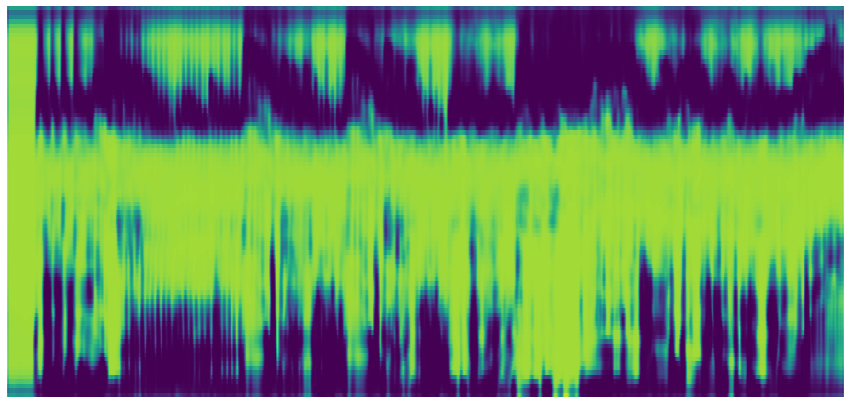

In [ ]:
from note_creation import model_output_to_notes
np_mats = {
    'note': np.asarray(output[1]).reshape(-1, 88),
    'onset': np.asarray(output[2]).reshape(-1, 88),
    'contour': np.asarray(output[0]).reshape(-1, 264)
}

# print(np_mats['note'])

plot_mat(np_mats['note'].T)
pm_predicted, note_events = model_output_to_notes(np_mats, 0.15, 0.05, include_pitch_bends=True, min_note_len=1, melodia_trick=False)

predicted_audio = pm_predicted.synthesize(fs=22050)[:22050 * duration]
predicted = Audio(predicted_audio, rate=22050)
display(predicted)

### Basic Pitch predicted audio and MIDI
We know you probably don't have the compute available to train this model to useful results,; however, we still want you to see and hear the capabilities of this model, so these are the outputs from the published version of the model.

Predicting MIDI for raw_audio_chopped.wav...


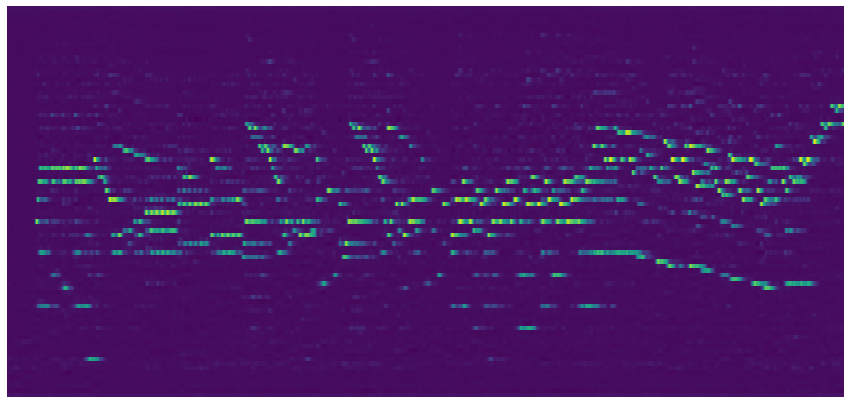

In [ ]:
from scipy.io.wavfile import write

output_path = "raw_audio_chopped.wav"
write(output_path, rate=22050, data=raw_audio)

from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH

model_output, midi_data, note_activations = predict(output_path)

plot_mat(model_output['note'].T)

bp_audio = midi_data.synthesize(fs=22050)[:22050 * duration]
bp = Audio(bp_audio, rate=22050)
display(bp)